# Derivation of which samples to use for Train, Valid, and Test set

In [1]:
import os

# Initialization
lowest_level = 2
highest_level = 3
train_val_stride = 200
test_stride = 299
tissue_p_min = 50

dir = '/content/drive/MyDrive/Applied_Deep_Learning_Project/'
current_dir = 'Lev_23_split_933_stride_200_pmin_50'
saving_dir = os.path.join(dir,current_dir)
saving_dir

'/content/drive/MyDrive/Applied_Deep_Learning_Project/Lev_23_split_933_stride_200_pmin_50'

In [2]:
# Mount drive
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)
print()

# Check TensorFlow version
import tensorflow as tf 
print("TF version: ", tf.__version__)
print()

# Check which GPU with available RAM
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

Mounted at /content/drive

TF version:  2.4.0

Found GPU at: /device:GPU:0
name, driver_version, memory.total [MiB]
Tesla P100-PCIE-16GB, 418.67, 16280 MiB


In [3]:
!apt-get install openslide-tools  # Openslide , Install the OpenSlide C library and Python bindings
!apt-get install python3-openslide # After installing these libraries, use `Runtime -> restart and run all` on the menu

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (113 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [4]:
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version

from openslide import open_slide, __library_version__ as openslide_version
import os
# from PIL import Image
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from itertools import chain
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from matplotlib.patches import Rectangle
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def get_open_slide(tissue_path, mask_path, return_tissue):
# Function that opens an image based on path
# Note: return_tissue = boolean value, 
#      Ture -> reads tissue img, False -> reads masks image

  slide = open_slide(tissue_path)
  print ("Read WSI from %s with width: %d, height: %d" % (tissue_path, 
                                                          slide.level_dimensions[0][0], 
                                                          slide.level_dimensions[0][1]))
  mask = open_slide(mask_path)
  print ("Read tumor mask from %s" % (mask_path))

  print("Slide includes %d levels", min(len(slide.level_dimensions),len(mask.level_dimensions)))
  for i in range(min(len(slide.level_dimensions),len(mask.level_dimensions))):
      print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                              slide.level_dimensions[i], 
                                                              slide.level_downsamples[i]))
      assert mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
      assert mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

  if (return_tissue):
    return slide
  else:
    return mask

In [6]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0. 
# There is an example below of working with coordinates with respect to a higher zoom level.

# Read a region from the slide, Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [7]:
# Gets difference of two lists using set operator
def difference(L1, L2):
    return (list(list(set(L1)-set(L2)) + list(set(L2)-set(L1))))

# detect and remove if number of images and masks are different
def balance_imgs(image_path_l, mask_path_l):
  img_num_l = [re.findall(r'\d+', string)[0] for string in image_path_l ] # list of image numbers
  mask_num_l = [re.findall(r'\d+', string)[0] for string in mask_path_l ] # list of mask's image numbers

  img_len = len(img_num_l)
  mask_len = len(mask_num_l)

  # delete images that are not same in number of lengths automatically
  if img_len != mask_len:
    print("Tissue image length: {}".format(len(image_path_l)))
    print("Mask image length: {}".format(len(mask_path_l)))

    diff_img_num = difference(img_num_l,mask_num_l)[0]

    if img_len > mask_len: # i.e. need to find extra image and delete
      print("Removed image number {} since there is no corresponding biopsy image".format(diff_img_num))
      del image_path_l[img_num_l.index(diff_img_num)]

    else: 
      print("Removed mask number {} since there is no corresponding  image".format(diff_img_num))
      del mask_path_l[mask_num_l.index(diff_img_num)]

  return image_path_l, mask_path_l

In [8]:
# Note: since importing slides from Professor's Google API does not work sometimes,
# we downloaded the images to 'locally' in Google Drive
directory = '/content/drive/MyDrive/Applied_Deep_Learning_Project/slides_local/'

biopsy_path_list = []
mask_path_list = []

for file in os.scandir(directory):
  
  if ("tif" in file.name):
    if ("mask" in file.name):
      mask_path_list.append(file.path) 
  
    else:
      biopsy_path_list.append(file.path)

# # Automatically removes images that are not both exists in image and masks
biopsy_path_list,mask_path_list = balance_imgs(biopsy_path_list,mask_path_list)

biopsy_path_list.sort()
mask_path_list.sort()

Tissue image length: 22
Mask image length: 21
Removed image number 038 since there is no corresponding biopsy image


####  Since the number of biopsy and mask images are different, image number 38 got deleted from the initially given sample. Also, we removed some other biopsy/mask images that do not have cancer percentage high enough.<br>

### Picture of Biopsy and Mask images

In [25]:
biopsy_slides = [get_open_slide(x,y,True) for x,y in zip(biopsy_path_list, mask_path_list)] # Ture -> reads tumor img, False -> reads masks image
mask_slides = [get_open_slide(x,y,False) for x,y in zip(biopsy_path_list, mask_path_list)]

Read WSI from /content/drive/MyDrive/Applied_Deep_Learning_Project/slides_local/tumor_001.tif with width: 97792, height: 221184
Read tumor mask from /content/drive/MyDrive/Applied_Deep_Learning_Project/slides_local/tumor_001_mask.tif
Slide includes %d levels 9
Level 0, dimensions: (97792, 221184) downsample factor 1
Level 1, dimensions: (48896, 110592) downsample factor 2
Level 2, dimensions: (24448, 55296) downsample factor 4
Level 3, dimensions: (12224, 27648) downsample factor 8
Level 4, dimensions: (6112, 13824) downsample factor 16
Level 5, dimensions: (3056, 6912) downsample factor 32
Level 6, dimensions: (1528, 3456) downsample factor 64
Level 7, dimensions: (764, 1728) downsample factor 128
Level 8, dimensions: (382, 864) downsample factor 256
Read WSI from /content/drive/MyDrive/Applied_Deep_Learning_Project/slides_local/tumor_002.tif with width: 97792, height: 219648
Read tumor mask from /content/drive/MyDrive/Applied_Deep_Learning_Project/slides_local/tumor_002_mask.tif
Slid

In [26]:
def extract_img_numbers(string_list):
  int_list = []
  for str in string_list:
    img_num = re.findall(r'\d+', str)[0]
    int_list.append(int(img_num))

  return sorted(int_list)

In [43]:
def plot_biopsy_mask_img(i_range_list):
  img_num_list = extract_img_numbers(biopsy_path_list) # img number's list

  for index in i_range_list:
    base_level = 5 # just for faster printing
    biopsy_slide = biopsy_slides[index]
    mask_slide = mask_slides[index]

    biopsy_img = read_slide(biopsy_slide, x=0, y=0, level=base_level, 
                            width=biopsy_slide.level_dimensions[base_level][0], 
                            height=biopsy_slide.level_dimensions[base_level][1])
    mask_img = read_slide(mask_slide, x=0, y=0, level = base_level, 
                          width=mask_slide.level_dimensions[base_level][0], 
                          height=mask_slide.level_dimensions[base_level][1])
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,5))
    fig.suptitle("Image index: {}, Image number: {}".format(index,img_num_list[index]), y=1.01);
    axes[0].imshow(biopsy_img)
    axes[0].set_title("Original Biopsy Image")
    axes[1].imshow(mask_img[:,:,0])
    axes[1].set_title("Original Mask Image") 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


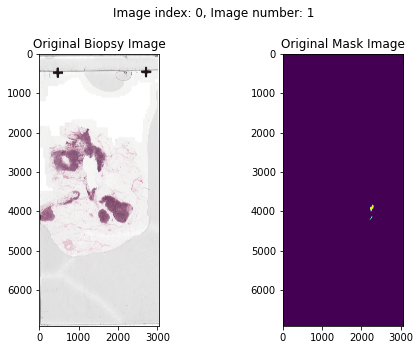

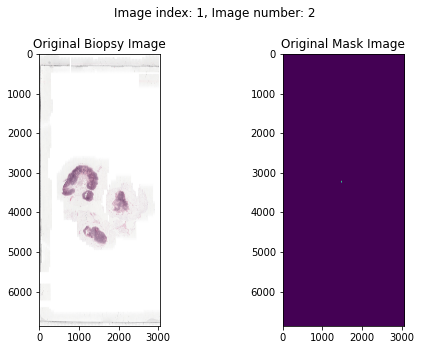

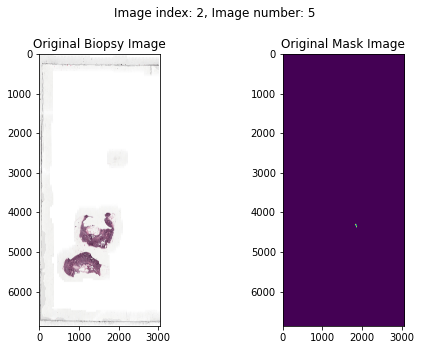

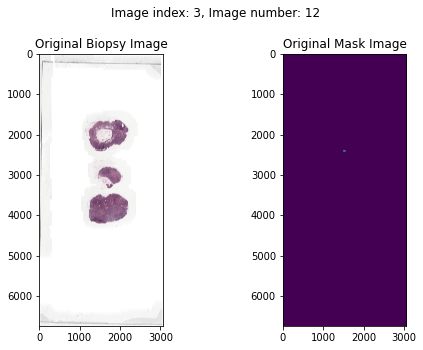

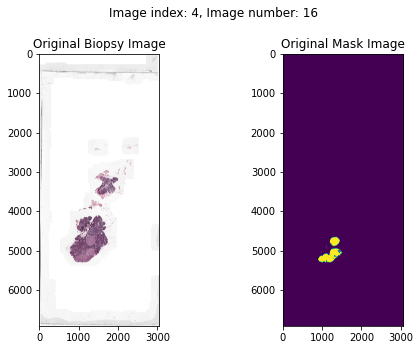

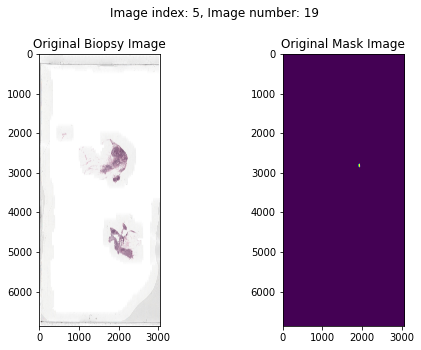

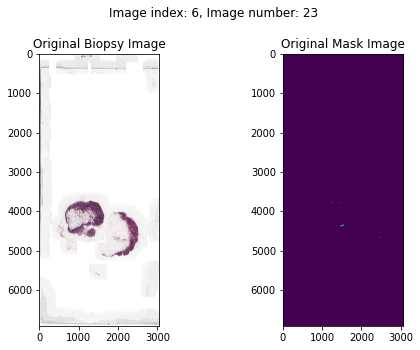

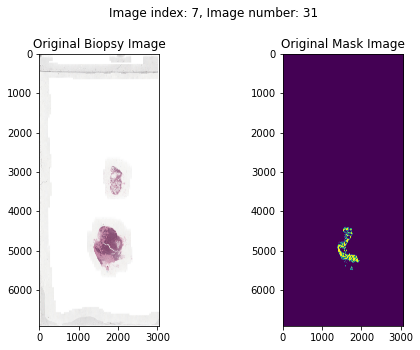

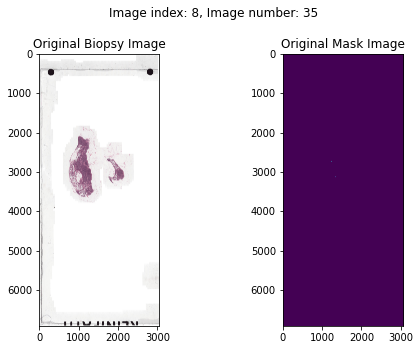

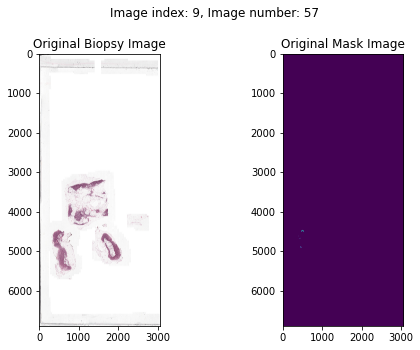

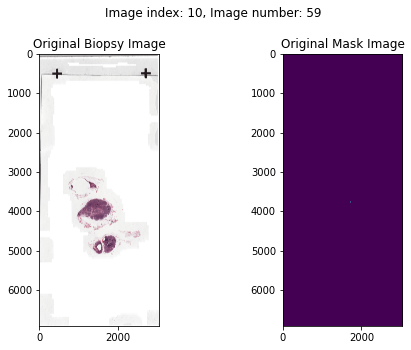

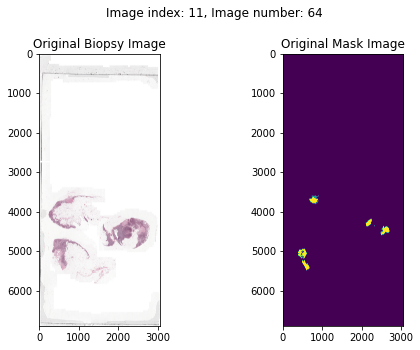

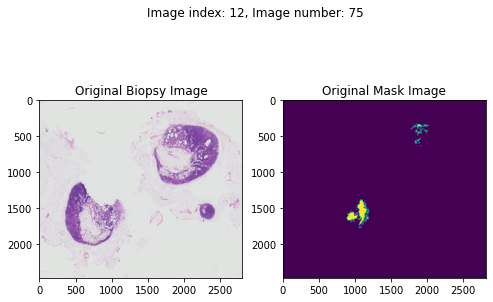

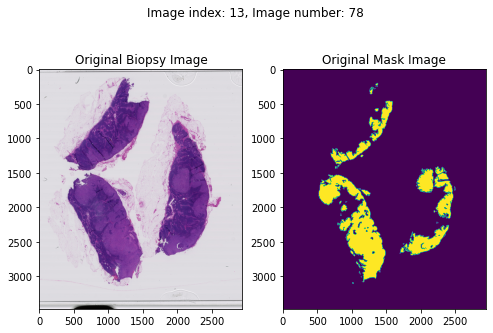

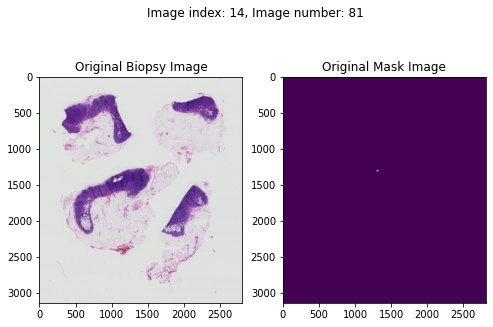

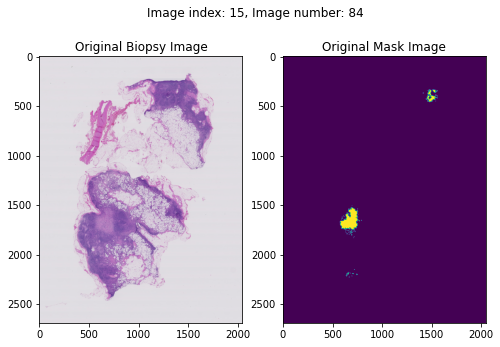

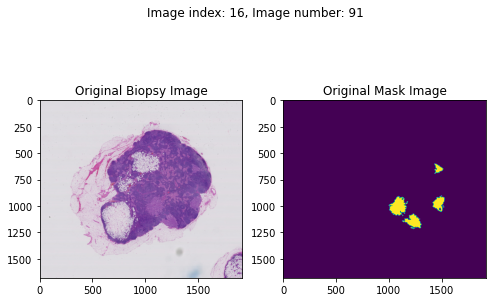

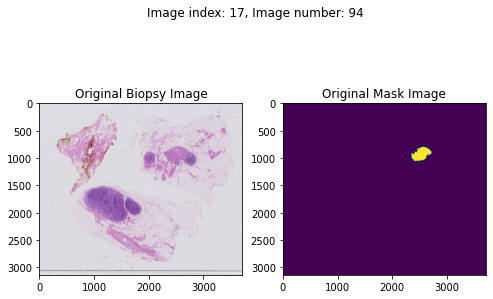

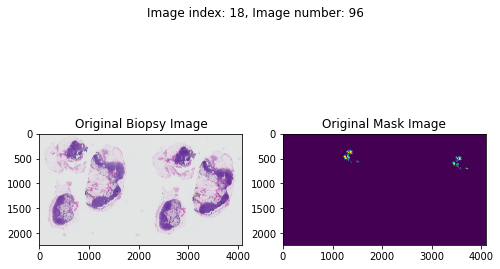

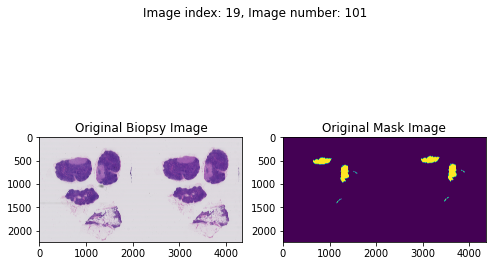

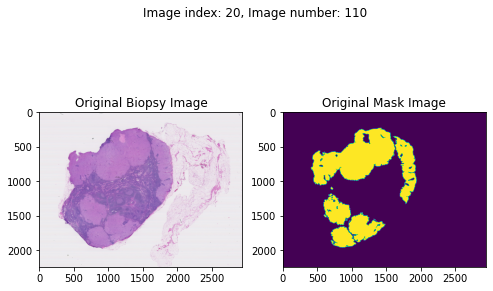

In [44]:
plot_biopsy_mask_img(range(len(biopsy_path_list)))

### We deicided to only use 15 samples out of 21 samples, since the 6 images rarely have any marks on the mask images(please refer below). Futher we picked images that goes into train/val/test set such that 'good' biopsy and mask images are distributed more toward training set and test set (i.e. put rather 'poor' images in validataion set since the set is used only for validation, and our goal is to have best prediction on the test set as much as we can).

In [45]:
train_index = [2,4,5,6,7,15,17,19,20]
valid_index = [0,12,18]
test_index = [11,13,16]
not_used_index = [1,3,8,9,10,14]

biopsy_train = [biopsy_path_list[i] for i in train_index]
biopsy_test = [biopsy_path_list[i] for i in test_index]
biopsy_valid = [biopsy_path_list[i] for i in valid_index]
mask_train = [mask_path_list[i] for i in train_index]
mask_test = [mask_path_list[i] for i in test_index]
mask_valid = [mask_path_list[i] for i in valid_index]

In [46]:
print("Total num of samples used: ", len(biopsy_train) + len(biopsy_valid) +len(biopsy_test))
print("Number of samples NOT used:", len(not_used_index))
print()
print("Each train/val/test set length: \n biopsy -> train: {} val: {} test: {} \n Mask -> train: {} val: {} test: {}".format(
     len(biopsy_train), len(biopsy_valid), len(biopsy_test), 
     len(mask_train), len(mask_valid), len(mask_test)  ))

print()
print("Biopsy img number in train set: {}".format(extract_img_numbers(biopsy_train)))
print("Biopsy img number in valid set: {}".format(extract_img_numbers(biopsy_valid)))
print("Biopsy img number in test set: {}".format(extract_img_numbers(biopsy_test)))

Total num of samples used:  15
Number of samples NOT used: 6

Each train/val/test set length: 
 biopsy -> train: 9 val: 3 test: 3 
 Mask -> train: 9 val: 3 test: 3

Biopsy img number in train set: [5, 16, 19, 23, 31, 84, 94, 101, 110]
Biopsy img number in valid set: [1, 75, 96]
Biopsy img number in test set: [64, 78, 91]


## Samples used in Train set

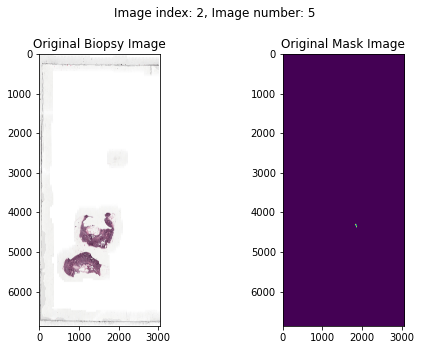

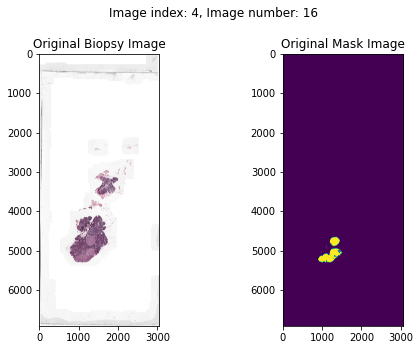

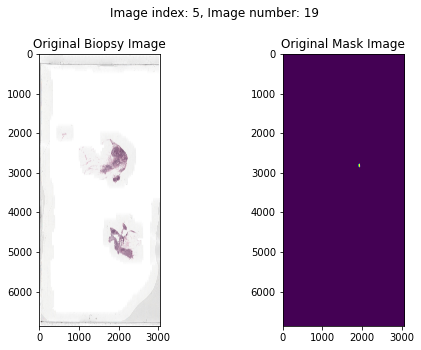

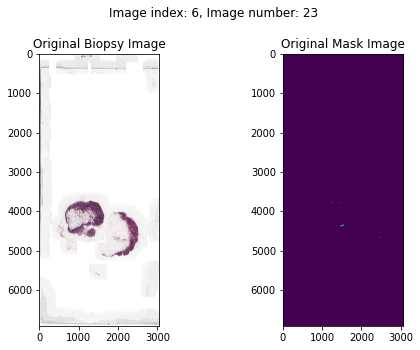

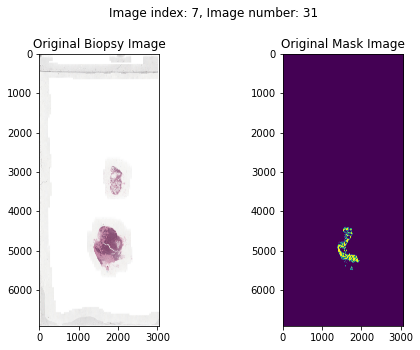

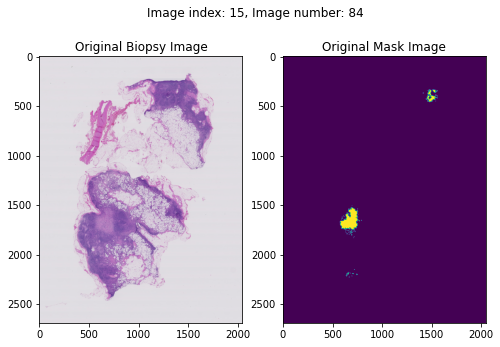

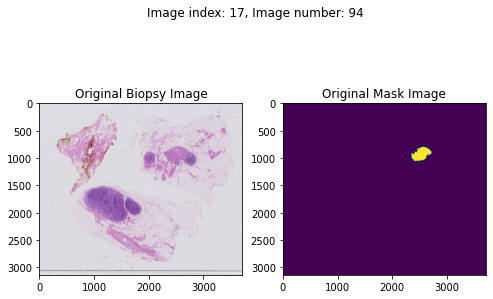

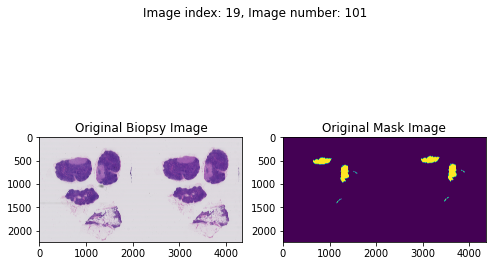

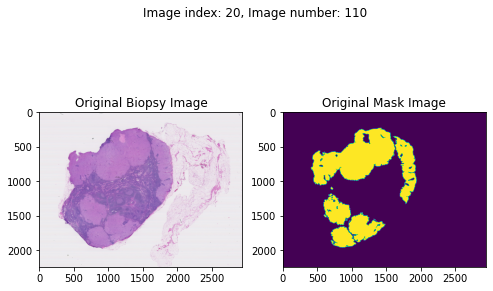

In [48]:
plot_biopsy_mask_img(train_index)

## Samples used in Validation set

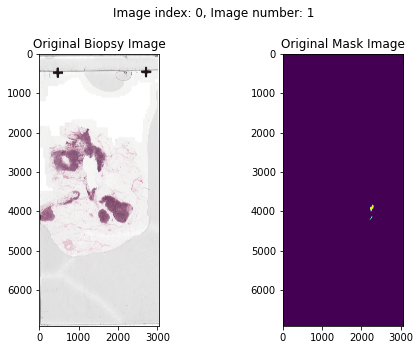

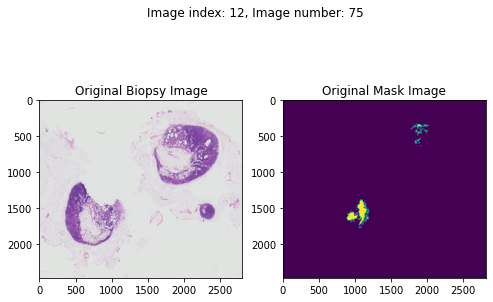

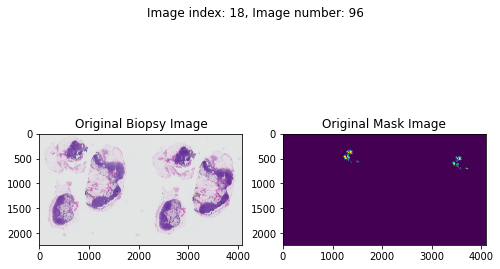

In [49]:
plot_biopsy_mask_img(valid_index)

## Samples used in Test set

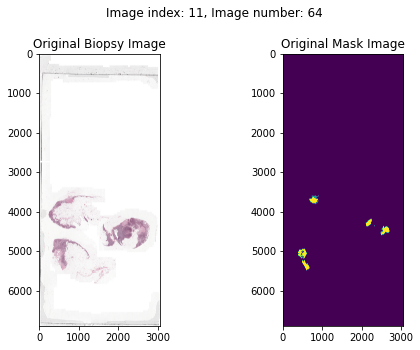

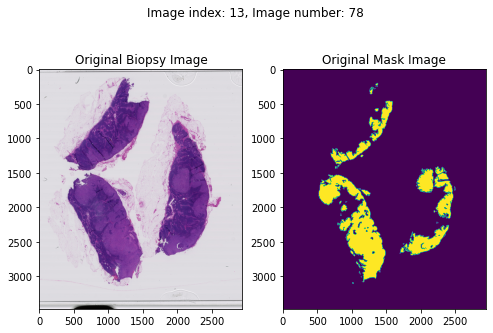

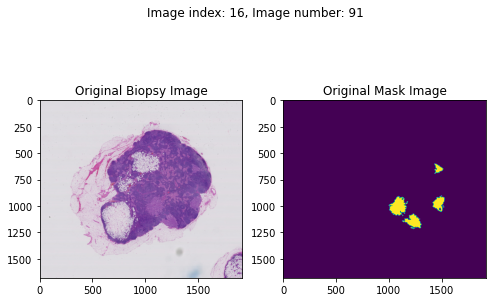

In [50]:
plot_biopsy_mask_img(test_index)

## Samples Not used

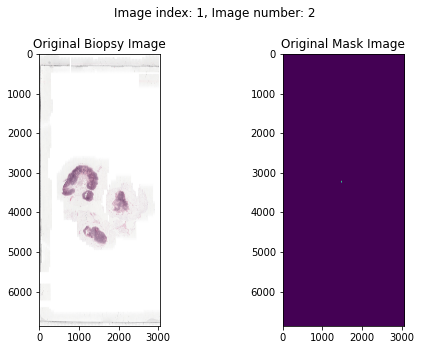

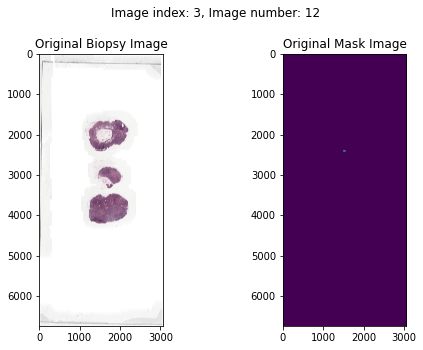

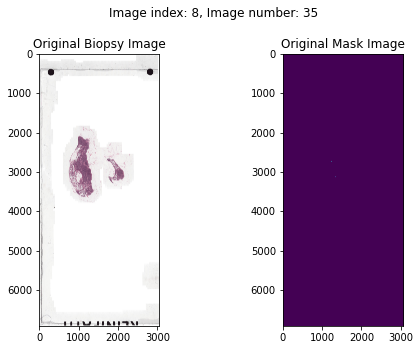

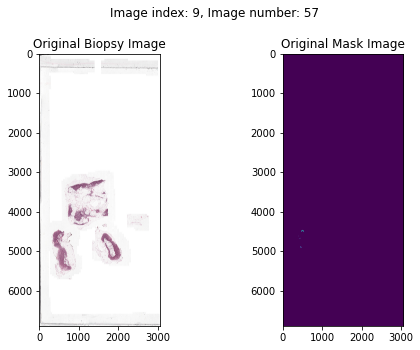

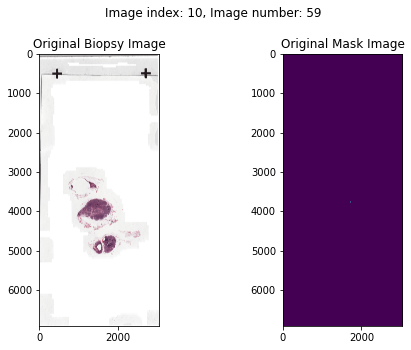

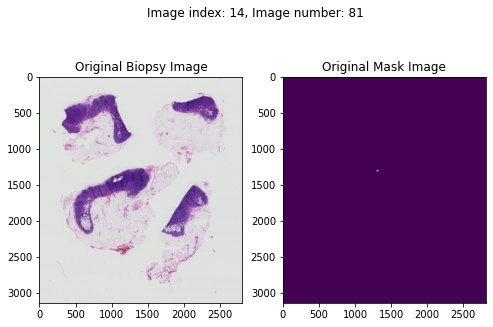

In [51]:
plot_biopsy_mask_img(not_used_index)